In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from datetime import datetime

from graphviz import Source

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import tree, ensemble
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report
from geopy.geocoders import Nominatim
from geopy.distance import great_circle
from scipy import stats
from selenium import webdriver
from selenium.webdriver.common.by import By
from multiprocessing import Pool
from selenium.common.exceptions import ElementNotInteractableException, ElementClickInterceptedException, StaleElementReferenceException, NoSuchElementException

/Users/thomastruyts/opt/anaconda3/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/thomastruyts/opt/anaconda3/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizat

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


## Input data

In [55]:
airport_codes = ["MUC", "BCN", "IST", "AMS", "FCO", "MAD", "LGW", "CDG", "ARN", "DUB", "LHR", "ZRH", "CPH","FRA", "OSL", "PMI", "BCN", "BRU", "HEL", "VCE", "ATH", "BCN", "SVO", "BCN", "DUS", "HAM","PRG", "MXP", "ORY", "GVA", "BCN", "TXL", "LIS", "BCN", "EDI", "BUD", "ATH", "WAW", "BCN", "VIE", "CPH"]


reis = 'enkel'

# Randomly select 50 airport codes from the list
iata_dep = random.sample(airport_codes, 24)

remaining_codes = [code for code in airport_codes if code not in iata_dep]

# Randomly select 50 airport codes for arrival airports
iata_arr = random.sample(remaining_codes, 10) 


Adults = ['1']
Children = ['0']
Babies = ['0']

today = datetime.date.today()
future = today + datetime.timedelta(days=300)  # Next year from today

date_list = []
for _ in range(50):
    random_date = today + datetime.timedelta(days=random.randint(0, (future - today).days))
    formatted_date = random_date.strftime('%Y-%m-%d')
    date_list.append(formatted_date)

## Functions

In [56]:
def flight_scraper(reis, Adults, Children, Babies, departure_city, destination_city, departure_date):
    
    if reis == 'retour':
        url = 'https://www.cheaptickets.nl/vluchtresultaten?adt=' + Adults + '&chd=' + Children + '&cls=Y&inf=' + Babies + '&out0_dep_all=false&out0_arr_all=false&out0_dep=' + departure_city +'&out0_arr=' + destination_city + '&out0_date=' + departure_date + '&in0_date=' + return_date
    else:
        url = 'https://www.cheaptickets.nl/vluchtresultaten?adt=' + Adults + '&chd=' + Children + '&cls=Y&inf=' + Babies + '&out0_arr=' + destination_city + '&out0_arr_all=false&out0_date=' + departure_date + '&out0_dep=' + departure_city + '&out0_dep_all=false'
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(5)
    
    try:
        cookie = driver.find_element("xpath","//button[@data-xivart-elm='cookie-consent-modal__accept-button']")
        cookie.click()
    except NoSuchElementException:
        cookie = driver.find_element("xpath","//button[@data-gf-id='btn-consent-standard']")
        cookie.click()
        
    time.sleep(20)
    
    moreresults = driver.find_elements("xpath", "//button[@class='outlined-button gtm-btn-flightresults-more button--ghost']")
    if len(moreresults) > 0:
        moreresults[0].click()
    
    prices = driver.find_elements("xpath","//div[@class='ui-price__integers']")
    prices_list = []

    for price in prices:
        num = price.text
        num = ''.join(filter(str.isdigit, num))
        prices_list.append(int(num))
    
    if len(prices_list) == 0:
        print(f"No flight between {departure_city} to {destination_city}, with {Adults} adults, {Children} children, {Babies} babies, and on {departure_date}")
    else:
        length = len(prices_list)
        departure_date_list = [departure_date] * length
        
        today = datetime.datetime.today()
        weekday = today.strftime("%A")
        weekday_list = [weekday] * length
        
        today_date = str(datetime.date.today())
        today_date_list = [today_date] * length

        times_check_list = []
        
        times = driver.find_elements(by='class name', value='flight-info__departure-time')
        times_list_departure = []

        for time1 in times:
            times_list_departure.append(str(time1.text))

        times = driver.find_elements(by='class name', value='flight-info__arrival-time')
        times_list_arrival = []

        for time1 in times:
            times_list_arrival.append(str(time1.text))

        for index, value in enumerate(times_list_arrival):
            if index % 2 != 1:  # if the index is odd
                times_list_arrival[index] = None  # remove the value by setting it to None

        times_list_arrival = [value for value in times_list_arrival if value is not None]  # create a new list without the removed values

        names = driver.find_elements("xpath","//div[@class='flight-info__name']")
        names_list = []

        for name in names:
            names_list.append(str(name.text))

        element_rest =  driver.find_elements(by='class name', value='flight-info__travel-time')
        elements = []

        for element_r in element_rest:
            elements.append(str(element_r.text))

        flighttypes =  driver.find_elements(by='class name', value='flight-info__flight-type')
        flighttype_list = []

        for flighttype in flighttypes:
            flighttype_list.append(str(flighttype.text))
            
            ## tijdstip van boeking
            now = datetime.datetime.now()
            time_check = now.strftime("%H") + 'h'
            times_check_list.append(time_check)        

        if reis == 'retour':
            df = pd.DataFrame(
            {'Prices': prices_list,
             'Time departure outward': times_list_departure[::2],
             'Time arrival outward': times_list_arrival[::2],
             'Time departure return': times_list_departure[1::2],
             'Time arrival return': times_list_arrival[1::2],
             'Airport departure outward':names_list[::4],
             'Airport arrival outward':names_list[1::4],
             'Airport departure return':names_list[2::4],
             'Airport arrival return':names_list[3::4],
             'Flighttime outward': elements[::2],
             'Flighttime return': elements[1::2],
             'Stops outward': flighttype_list[::2],
             'Stops return': flighttype_list[1::2]
            })
        else:
            df = pd.DataFrame(
            {'Prices': prices_list,
             'Time_departure': times_list_departure,
             'Time_arrival': times_list_arrival,
             'Airport_departure':names_list[::2],
             'Airport_arrival':names_list[1::2],
             'Flight_time': elements,
             'Stops': flighttype_list,
             'Flight_date': departure_date_list,
             'Check_weekday': weekday_list,
             'Check_time': times_check_list,
             'Check_date': today_date_list
            })
            
        print(f"Flights between {departure_city} and {destination_city} successfully added")
    
    return df


## Scraping

In [57]:
df_list = []
for i in range(100):
    adult = random.choice(Adults)
    child = random.choice(Children)
    baby = random.choice(Babies)
    departure_date = random.choice(date_list)
    departure_city = random.choice(iata_dep)
    destination_city = random.choice([code for code in airport_codes if code not in iata_dep])
    df = None 
    
    try:
        df = flight_scraper(reis, adult, child, baby, departure_city, destination_city, departure_date)
    except (ElementNotInteractableException, ElementClickInterceptedException, StaleElementReferenceException,UnboundLocalError) as e:
        print(f"Caught exception: {e}. Starting the loop again.")
        continue

    if df is not None:
        df_list.append(df)

final_df = pd.concat(df_list, ignore_index=True)

Caught exception: Message: element not interactable
  (Session info: chrome=113.0.5672.126)
Stacktrace:
0   chromedriver                        0x00000001033d9598 chromedriver + 4973976
1   chromedriver                        0x00000001033d0913 chromedriver + 4938003
2   chromedriver                        0x0000000102f8db50 chromedriver + 469840
3   chromedriver                        0x0000000102fd2ea6 chromedriver + 753318
4   chromedriver                        0x0000000102fc5671 chromedriver + 697969
5   chromedriver                        0x0000000102ff59c2 chromedriver + 895426
6   chromedriver                        0x0000000102fc4e51 chromedriver + 695889
7   chromedriver                        0x0000000102ff5b7e chromedriver + 895870
8   chromedriver                        0x0000000103010856 chromedriver + 1005654
9   chromedriver                        0x0000000102ff5793 chromedriver + 894867
10  chromedriver                        0x0000000102fc321f chromedriver + 688671
11

Caught exception: Message: element not interactable
  (Session info: chrome=113.0.5672.126)
Stacktrace:
0   chromedriver                        0x00000001033fc598 chromedriver + 4973976
1   chromedriver                        0x00000001033f3913 chromedriver + 4938003
2   chromedriver                        0x0000000102fb0b50 chromedriver + 469840
3   chromedriver                        0x0000000102ff5ea6 chromedriver + 753318
4   chromedriver                        0x0000000102fe8671 chromedriver + 697969
5   chromedriver                        0x00000001030189c2 chromedriver + 895426
6   chromedriver                        0x0000000102fe7e51 chromedriver + 695889
7   chromedriver                        0x0000000103018b7e chromedriver + 895870
8   chromedriver                        0x0000000103033856 chromedriver + 1005654
9   chromedriver                        0x0000000103018793 chromedriver + 894867
10  chromedriver                        0x0000000102fe621f chromedriver + 688671
11

Flights between BCN and LIS successfully added
Flights between DUS and FCO successfully added
Caught exception: Message: element not interactable
  (Session info: chrome=113.0.5672.126)
Stacktrace:
0   chromedriver                        0x0000000106703598 chromedriver + 4973976
1   chromedriver                        0x00000001066fa913 chromedriver + 4938003
2   chromedriver                        0x00000001062b7b50 chromedriver + 469840
3   chromedriver                        0x00000001062fcea6 chromedriver + 753318
4   chromedriver                        0x00000001062ef671 chromedriver + 697969
5   chromedriver                        0x000000010631f9c2 chromedriver + 895426
6   chromedriver                        0x00000001062eee51 chromedriver + 695889
7   chromedriver                        0x000000010631fb7e chromedriver + 895870
8   chromedriver                        0x000000010633a856 chromedriver + 1005654
9   chromedriver                        0x000000010631f793 chromedrive

Caught exception: Message: element not interactable
  (Session info: chrome=113.0.5672.126)
Stacktrace:
0   chromedriver                        0x0000000105cc7598 chromedriver + 4973976
1   chromedriver                        0x0000000105cbe913 chromedriver + 4938003
2   chromedriver                        0x000000010587bb50 chromedriver + 469840
3   chromedriver                        0x00000001058c0ea6 chromedriver + 753318
4   chromedriver                        0x00000001058b3671 chromedriver + 697969
5   chromedriver                        0x00000001058e39c2 chromedriver + 895426
6   chromedriver                        0x00000001058b2e51 chromedriver + 695889
7   chromedriver                        0x00000001058e3b7e chromedriver + 895870
8   chromedriver                        0x00000001058fe856 chromedriver + 1005654
9   chromedriver                        0x00000001058e3793 chromedriver + 894867
10  chromedriver                        0x00000001058b121f chromedriver + 688671
11

Caught exception: Message: element not interactable
  (Session info: chrome=113.0.5672.126)
Stacktrace:
0   chromedriver                        0x0000000108b8f598 chromedriver + 4973976
1   chromedriver                        0x0000000108b86913 chromedriver + 4938003
2   chromedriver                        0x0000000108743b50 chromedriver + 469840
3   chromedriver                        0x0000000108788ea6 chromedriver + 753318
4   chromedriver                        0x000000010877b671 chromedriver + 697969
5   chromedriver                        0x00000001087ab9c2 chromedriver + 895426
6   chromedriver                        0x000000010877ae51 chromedriver + 695889
7   chromedriver                        0x00000001087abb7e chromedriver + 895870
8   chromedriver                        0x00000001087c6856 chromedriver + 1005654
9   chromedriver                        0x00000001087ab793 chromedriver + 894867
10  chromedriver                        0x000000010877921f chromedriver + 688671
11

Caught exception: Message: element not interactable
  (Session info: chrome=113.0.5672.126)
Stacktrace:
0   chromedriver                        0x0000000107de3598 chromedriver + 4973976
1   chromedriver                        0x0000000107dda913 chromedriver + 4938003
2   chromedriver                        0x0000000107997b50 chromedriver + 469840
3   chromedriver                        0x00000001079dcea6 chromedriver + 753318
4   chromedriver                        0x00000001079cf671 chromedriver + 697969
5   chromedriver                        0x00000001079ff9c2 chromedriver + 895426
6   chromedriver                        0x00000001079cee51 chromedriver + 695889
7   chromedriver                        0x00000001079ffb7e chromedriver + 895870
8   chromedriver                        0x0000000107a1a856 chromedriver + 1005654
9   chromedriver                        0x00000001079ff793 chromedriver + 894867
10  chromedriver                        0x00000001079cd21f chromedriver + 688671
11

Caught exception: Message: element not interactable
  (Session info: chrome=113.0.5672.126)
Stacktrace:
0   chromedriver                        0x000000010aafa598 chromedriver + 4973976
1   chromedriver                        0x000000010aaf1913 chromedriver + 4938003
2   chromedriver                        0x000000010a6aeb50 chromedriver + 469840
3   chromedriver                        0x000000010a6f3ea6 chromedriver + 753318
4   chromedriver                        0x000000010a6e6671 chromedriver + 697969
5   chromedriver                        0x000000010a7169c2 chromedriver + 895426
6   chromedriver                        0x000000010a6e5e51 chromedriver + 695889
7   chromedriver                        0x000000010a716b7e chromedriver + 895870
8   chromedriver                        0x000000010a731856 chromedriver + 1005654
9   chromedriver                        0x000000010a716793 chromedriver + 894867
10  chromedriver                        0x000000010a6e421f chromedriver + 688671
11

Flights between EDI and WAW successfully added
No flight between TXL to LIS, with 1 adults, 0 children, 0 babies, and on 2023-07-21
Caught exception: local variable 'df' referenced before assignment. Starting the loop again.
Caught exception: Message: element not interactable
  (Session info: chrome=113.0.5672.126)
Stacktrace:
0   chromedriver                        0x00000001068d0598 chromedriver + 4973976
1   chromedriver                        0x00000001068c7913 chromedriver + 4938003
2   chromedriver                        0x0000000106484b50 chromedriver + 469840
3   chromedriver                        0x00000001064c9ea6 chromedriver + 753318
4   chromedriver                        0x00000001064bc671 chromedriver + 697969
5   chromedriver                        0x00000001064ec9c2 chromedriver + 895426
6   chromedriver                        0x00000001064bbe51 chromedriver + 695889
7   chromedriver                        0x00000001064ecb7e chromedriver + 895870
8   chromedriver     

Caught exception: Message: element not interactable
  (Session info: chrome=113.0.5672.126)
Stacktrace:
0   chromedriver                        0x000000010b0f7598 chromedriver + 4973976
1   chromedriver                        0x000000010b0ee913 chromedriver + 4938003
2   chromedriver                        0x000000010acabb50 chromedriver + 469840
3   chromedriver                        0x000000010acf0ea6 chromedriver + 753318
4   chromedriver                        0x000000010ace3671 chromedriver + 697969
5   chromedriver                        0x000000010ad139c2 chromedriver + 895426
6   chromedriver                        0x000000010ace2e51 chromedriver + 695889
7   chromedriver                        0x000000010ad13b7e chromedriver + 895870
8   chromedriver                        0x000000010ad2e856 chromedriver + 1005654
9   chromedriver                        0x000000010ad13793 chromedriver + 894867
10  chromedriver                        0x000000010ace121f chromedriver + 688671
11

Caught exception: Message: element not interactable
  (Session info: chrome=113.0.5672.126)
Stacktrace:
0   chromedriver                        0x00000001029ed598 chromedriver + 4973976
1   chromedriver                        0x00000001029e4913 chromedriver + 4938003
2   chromedriver                        0x00000001025a1b50 chromedriver + 469840
3   chromedriver                        0x00000001025e6ea6 chromedriver + 753318
4   chromedriver                        0x00000001025d9671 chromedriver + 697969
5   chromedriver                        0x00000001026099c2 chromedriver + 895426
6   chromedriver                        0x00000001025d8e51 chromedriver + 695889
7   chromedriver                        0x0000000102609b7e chromedriver + 895870
8   chromedriver                        0x0000000102624856 chromedriver + 1005654
9   chromedriver                        0x0000000102609793 chromedriver + 894867
10  chromedriver                        0x00000001025d721f chromedriver + 688671
11

Caught exception: Message: element not interactable
  (Session info: chrome=113.0.5672.126)
Stacktrace:
0   chromedriver                        0x00000001017c8598 chromedriver + 4973976
1   chromedriver                        0x00000001017bf913 chromedriver + 4938003
2   chromedriver                        0x000000010137cb50 chromedriver + 469840
3   chromedriver                        0x00000001013c1ea6 chromedriver + 753318
4   chromedriver                        0x00000001013b4671 chromedriver + 697969
5   chromedriver                        0x00000001013e49c2 chromedriver + 895426
6   chromedriver                        0x00000001013b3e51 chromedriver + 695889
7   chromedriver                        0x00000001013e4b7e chromedriver + 895870
8   chromedriver                        0x00000001013ff856 chromedriver + 1005654
9   chromedriver                        0x00000001013e4793 chromedriver + 894867
10  chromedriver                        0x00000001013b221f chromedriver + 688671
11

In [58]:
#Save the scraping in an Excel file
final_df = pd.concat(df_list, ignore_index=True)
final_df.to_excel("scrape15.xlsx") 

## Load the data

In [11]:
## after merging all the excel scrapes
scrape1 = pd.read_excel('scrape1.xlsx')
scrape2 = pd.read_excel('scrape2.xlsx')
scrape3 = pd.read_excel('scrape3.xlsx')
scrape4 = pd.read_excel('scrape4.xlsx')
scrape5 = pd.read_excel('scrape5.xlsx')
scrape6 = pd.read_excel('scrape6.xlsx')
scrape7 = pd.read_excel('scrape7.xlsx')
scrape8 = pd.read_excel('scrape8.xlsx')
scrape9 = pd.read_excel('scrape9.xlsx')
scrape10 = pd.read_excel('scrape10.xlsx')
scrape11 = pd.read_excel('scrape11.xlsx')
scrape12 = pd.read_excel('scrape12.xlsx')
scrape13 = pd.read_excel('scrape13.xlsx')
scrape14 = pd.read_excel('scrape14.xlsx')

In [12]:
data = pd.concat([scrape1,scrape2,scrape3,scrape4,scrape5,scrape6,scrape7,scrape8,scrape9,
              scrape10,scrape11,scrape12,scrape13, scrape14])
data.head()

,Unnamed: 0,Prices,Time_departure,Time_arrival,Airport_departure,Airport_arrival,Flight_time,Stops,Flight_date,Check_weekday,Check_time,Check_date
0,0,1404,20:50,08:50,Tocumen Intl. Apt.,Narita Intl. Apt.,46u00m,1 stop,2023-07-02,Thursday,17h,2023-04-13
1,1,1480,22:55,15:00,Tocumen Intl. Apt.,Narita Intl. Apt.,26u05m,2 stops,2023-07-02,Thursday,17h,2023-04-13
2,2,1480,18:45,15:00,Tocumen Intl. Apt.,Narita Intl. Apt.,30u15m,1 stop,2023-07-02,Thursday,17h,2023-04-13
3,3,1485,15:30,16:30,Tocumen Intl. Apt.,Narita Intl. Apt.,35u00m,2 stops,2023-07-02,Thursday,17h,2023-04-13
4,4,1498,22:55,14:45,Tocumen Intl. Apt.,Narita Intl. Apt.,49u50m,2 stops,2023-07-02,Thursday,17h,2023-04-13


In [13]:
data.shape

(17942, 12)

## Feature Engineering

### Coordinates and distance between cities

Here the distance is calculated between the two cities of where the airports are located. By use of the geolocator library, the coordinates of both cities are calculated. Consequently, the distance is calculated by the great circle technique

In [14]:
## get the distinct aiports
values_list = sum(data[['Airport_departure', 'Airport_arrival']].values.tolist(), [])
unique_values_list = list(set(values_list))

In [15]:
# Create a geocoder object
geolocator = Nominatim(user_agent='my-app')

# Use the geocoder to find the coordinates of each city
city_coords = {}
for city in unique_values_list:
    location = geolocator.geocode(city)
    if location is not None:
        city_coords[city] = (location.latitude, location.longitude)

In [16]:
# Function to calculate the distance between two cities
def get_distance(row):
    dep_coords = city_coords.get(row['Airport_departure'])
    arr_coords = city_coords.get(row['Airport_arrival'])
    if dep_coords is not None and arr_coords is not None:
        return great_circle(dep_coords, arr_coords).km
    else:
        return None

# Apply the function to each row of the DataFrame to calculate distances
data['distance_km'] = data.apply(get_distance, axis=1)

# Print the updated DataFrame
data

,Unnamed: 0,Prices,Time_departure,Time_arrival,Airport_departure,Airport_arrival,Flight_time,Stops,Flight_date,Check_weekday,Check_time,Check_date,distance_km
0,0,1404,20:50,08:50,Tocumen Intl. Apt.,Narita Intl. Apt.,46u00m,1 stop,2023-07-02,Thursday,17h,2023-04-13,NaN
1,1,1480,22:55,15:00,Tocumen Intl. Apt.,Narita Intl. Apt.,26u05m,2 stops,2023-07-02,Thursday,17h,2023-04-13,NaN
2,2,1480,18:45,15:00,Tocumen Intl. Apt.,Narita Intl. Apt.,30u15m,1 stop,2023-07-02,Thursday,17h,2023-04-13,NaN
3,3,1485,15:30,16:30,Tocumen Intl. Apt.,Narita Intl. Apt.,35u00m,2 stops,2023-07-02,Thursday,17h,2023-04-13,NaN
4,4,1498,22:55,14:45,Tocumen Intl. Apt.,Narita Intl. Apt.,49u50m,2 stops,2023-07-02,Thursday,17h,2023-04-13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,866,162,07:10,10:40,Zaventem,Helsinki,02u30m,direct,2024-01-10,Wednesday,01h,2023-05-17,1639.4252
867,867,179,19:10,22:40,Zaventem,Helsinki,02u30m,direct,2024-01-10,Wednesday,01h,2023-05-17,1639.4252
868,868,219,16:40,23:10,Zaventem,Helsinki,05u30m,1 stop,2024-01-10,Wednesday,01h,2023-05-17,1639.4252
869,869,235,06:55,13:10,Zaventem,Helsinki,05u15m,1 stop,2024-01-10,Wednesday,01h,2023-05-17,1639.4252


In [17]:
## Delete those without distance (NaN)
data = data.dropna(subset=['distance_km'])
data = data.reset_index(drop=True)
data

,Unnamed: 0,Prices,Time_departure,Time_arrival,Airport_departure,Airport_arrival,Flight_time,Stops,Flight_date,Check_weekday,Check_time,Check_date,distance_km
0,20,367,08:15,18:45,Melbourne,Soekarno Hatta,13u30m,1 stop,2023-09-15,Thursday,17h,2023-04-13,5009.222867
1,21,378,10:00,18:45,Melbourne,Soekarno Hatta,11u45m,1 stop,2023-09-15,Thursday,17h,2023-04-13,5009.222867
2,22,390,15:10,19:15,Melbourne,Soekarno Hatta,07u05m,direct,2023-09-15,Thursday,17h,2023-04-13,5009.222867
3,23,404,17:15,18:45,Melbourne,Soekarno Hatta,28u30m,1 stop,2023-09-15,Thursday,17h,2023-04-13,5009.222867
4,24,408,14:25,13:10,Melbourne,Soekarno Hatta,25u45m,1 stop,2023-09-15,Thursday,17h,2023-04-13,5009.222867
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11630,866,162,07:10,10:40,Zaventem,Helsinki,02u30m,direct,2024-01-10,Wednesday,01h,2023-05-17,1639.425200
11631,867,179,19:10,22:40,Zaventem,Helsinki,02u30m,direct,2024-01-10,Wednesday,01h,2023-05-17,1639.425200
11632,868,219,16:40,23:10,Zaventem,Helsinki,05u30m,1 stop,2024-01-10,Wednesday,01h,2023-05-17,1639.425200
11633,869,235,06:55,13:10,Zaventem,Helsinki,05u15m,1 stop,2024-01-10,Wednesday,01h,2023-05-17,1639.425200


### Subregions and their high-mid-low season

For each subregion, the season is determined by the use of ChatGPT. My hypothesis is that tickets are more expensive in the high season of the destination country.

In [18]:
## determine the country based on the coordinates
city_country_code = {}

for city in city_coords.keys():
    location = geolocator.reverse(f"{city_coords[city][0]}, {city_coords[city][1]}")
    country = location.raw['address']['country_code']
    city_country_code[city] = country
    
# link all codes to subregions through chatgpt

In [19]:
# Unique values
country_codes = list(set(city_country_code.values()))

In [20]:
# chatgpt output
country_codes = {
  'Southeast Asia': ['vn', 'id', 'kg', 'th', 'ph'],
  'East Asia': ['cn', 'kr', 'jp'],
  'Europe': ['ie', 'at', 'lu', 'cz', 'fr', 'ro', 'dk', 'hu', 'nl', 'lt', 'fi', 'de', 'be', 'pt', 'ch', 'gb', 'hr', 'si', 'gr'],
  'North America': ['do', 'ca', 'us'],
  'Oceania': ['nz', 'au'],
  'Middle East': ['ae', 'kw', 'sa'],
  'Caribbean and South America': ['cl', 'co', 'mu', 'sn', 'br', 'pe', 'mx'],
  'South Africa': ['za'],
  'North Africa': ['eg', 'dz']
}

In [21]:
seasons = {
"Southeast Asia": {
"Low season": [5, 6, 7, 8, 9],
"Mid season": [11, 10, 4, 3],
"High season": [12, 1, 2]
},
"East Asia": {
"Low season": [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
"Mid season": [3, 4, 5, 9, 10, 11],
"High season": [6, 7, 8]
},
"Europe": {
"Low season": [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
"Mid season": [4, 5, 6, 9, 10],
"High season": [7, 8]
},
"North America": {
"Low season": [11, 10, 9, 8, 7, 6, 5, 4],
"Mid season": [5, 6, 9, 10],
"High season": [7, 8]
},
"Oceania": {
"Low season": [5, 6, 7, 8],
"Mid season": [3, 4, 9, 10, 11],
"High season": [12, 1, 2]
},
"Middle East": {
"Low season": [5, 6, 7, 8, 9],
"Mid season": [10, 11, 12, 1, 2, 3, 4],
"High season": []
},
"Caribbean and South America": {
"Low season": [6, 7, 8, 9, 10, 11],
"Mid season": [12, 11, 10, 9, 8, 4, 5, 9, 10, 11],
"High season": [3]
},
"North Africa": {
"Low season": [11, 12, 1, 2],
"Mid season": [3, 4, 5, 9, 10],
"High season": [6, 7, 8]
}
}

In [22]:
# Link the seasons to each destination
for i in range(0,len(data)):
    arrival_dest = data.iloc[i]['Airport_arrival'] 
    country_code = city_country_code[arrival_dest]
    
    date_str = data.iloc[i]['Flight_date'] 
    date_obj = datetime.datetime.strptime(date_str, '%Y-%m-%d')

    # Get the month of the date as an integer
    month = date_obj.month

    # Initialize an empty list to store the matching keys
    matching_keys = []

    # Loop over the dictionary and check if the search string is in each list of values
    for key, value_list in country_codes.items():
        if country_code in value_list:
            subregion = key
            if subregion in list(seasons.keys()):
                for season, month_list in seasons[subregion].items():
                    if month in month_list:
                        print(season)
                        data.loc[i, 'season'] = season

Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
L

Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
H

Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
M

Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season

Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season

Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Mid season
Mid season

High season
High season
High season
High season
High season
High season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Mid season
Mid season
Mid season
Mid season
Mid 

Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season

Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
Mid season
M

High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low

Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Lo

Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season

Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low s

Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season

Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season

Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season
Low season
Mid season

Low season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
High season
Low season
Low season
Low season
Low season
Low season
Low season
Low

In [23]:
# Delete NaN values
data = data.dropna(subset=['season'])
data = data.reset_index(drop=True)

## Feature creation

In [24]:
data["Flight_date"] = pd.to_datetime(data["Flight_date"], format = "%Y-%m-%d")
data["Check_date"] = pd.to_datetime(data["Check_date"], format = "%Y-%m-%d")

data["flight_check_diff"] = data["Flight_date"] - data["Check_date"]
data["flight_check_diff"] = data["flight_check_diff"].dt.days

In [25]:
def duration_to_hours(duration_str):
    hours, minutes = duration_str.split("u")
    minutes = minutes.replace("m", "")  # remove the "m" suffix
    return float(hours) + float(minutes) / 60

# Apply the function to the entire duration column
data["Flight_time"] = data["Flight_time"].apply(duration_to_hours)

In [26]:
# Extracting date features as numbers from dteday
data['day_flight']= [day.day for day in data['Flight_date']]
data['month_flight']= [day.month for day in data['Flight_date']]
data['year_flight']= [day.year for day in data['Flight_date']]
data['day_of_week_flight'] = [value.dayofweek for value in data['Flight_date']]
data['weekend_flight'] = [1 if value in [5, 6] else 0 for value in data['day_of_week_flight']]

In [27]:
def weekday_to_number(weekday_name):
    weekday_dict = {
        "Monday": 0,
        "Tuesday": 1,
        "Wednesday": 2,
        "Thursday": 3,
        "Friday": 4,
        "Saturday": 5,
        "Sunday": 6,
    }
    return weekday_dict[weekday_name]

# Apply the function to the entire weekday column
data["day_of_week_check"] = data["Check_weekday"].apply(lambda x: weekday_to_number(x))

In [28]:
# Extracting date features as numbers from dteday
data['day_check']= [day.day for day in data['Check_date']]
data['month_check']= [day.month for day in data['Check_date']]
data['year_check']= [day.year for day in data['Check_date']]
data['weekend_check'] = [1 if value in [5, 6] else 0 for value in data['day_of_week_check']]

In [29]:
# Is this the right amount of bins?
def duration_to_hours(duration_str):
    hours = duration_str[:2]
    return hours

# Apply the function to the entire duration column
data["Time_departure"] = data["Time_departure"].apply(duration_to_hours)
data["Time_arrival"] = data["Time_arrival"].apply(duration_to_hours)
data["Check_time"] = data["Check_time"].apply(duration_to_hours)

data["Time_departure"] = data["Time_departure"].astype(int)
data["Time_arrival"] = data["Time_arrival"].astype(int)
data["Check_time"] = data["Check_time"].astype(int)

In [30]:
##binning of times

# Define the bin edges
bin_edges = [-1, 6, 12, 18, 24]

# Define the bin labels
bin_labels = ["night", "morning", "afternoon", "evening"]

# Create a new column with the time bins
data["time_departure_bins"] = pd.cut(data["Time_departure"], bins=bin_edges, labels=bin_labels)
data["time_arrival_bins"] = pd.cut(data["Time_arrival"], bins=bin_edges, labels=bin_labels)
data["check_time_bins"] = pd.cut(data["Check_time"], bins=bin_edges, labels=bin_labels)

In [31]:
category_mapping = {'direct': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4, '5 stops': 5}

# Create a new column with the encoded values
data['Stops'] = data['Stops'].map(category_mapping)

In [32]:
# Save the original data with the new features
data_eng = data.copy()

## EDA

In [3]:
data = pd.read_excel("data_to_use.xlsx")

In [4]:
data.isnull().any()

Unnamed: 0             False
Prices                 False
Time_departure         False
Time_arrival           False
Airport_departure      False
Airport_arrival        False
Flight_time            False
Stops                  False
Flight_date            False
Check_weekday          False
Check_time             False
Check_date             False
distance_km            False
season                 False
flight_check_diff      False
day_flight             False
month_flight           False
year_flight            False
day_of_week_flight     False
weekend_flight         False
day_of_week_check      False
day_check              False
month_check            False
year_check             False
weekend_check          False
time_departure_bins    False
time_arrival_bins      False
check_time_bins        False
dtype: bool

In [5]:
data.isna().any()

Unnamed: 0             False
Prices                 False
Time_departure         False
Time_arrival           False
Airport_departure      False
Airport_arrival        False
Flight_time            False
Stops                  False
Flight_date            False
Check_weekday          False
Check_time             False
Check_date             False
distance_km            False
season                 False
flight_check_diff      False
day_flight             False
month_flight           False
year_flight            False
day_of_week_flight     False
weekend_flight         False
day_of_week_check      False
day_check              False
month_check            False
year_check             False
weekend_check          False
time_departure_bins    False
time_arrival_bins      False
check_time_bins        False
dtype: bool

In [6]:
data.dtypes

Unnamed: 0                      int64
Prices                          int64
Time_departure                  int64
Time_arrival                    int64
Airport_departure              object
Airport_arrival                object
Flight_time                   float64
Stops                           int64
Flight_date            datetime64[ns]
Check_weekday                  object
Check_time                      int64
Check_date             datetime64[ns]
distance_km                   float64
season                         object
flight_check_diff               int64
day_flight                      int64
month_flight                    int64
year_flight                     int64
day_of_week_flight              int64
weekend_flight                  int64
day_of_week_check               int64
day_check                       int64
month_check                     int64
year_check                      int64
weekend_check                   int64
time_departure_bins            object
time_arrival

In [7]:
data.describe()

,Unnamed: 0,Prices,Time_departure,Time_arrival,Flight_time,Stops,Check_time,distance_km,flight_check_diff,day_flight,month_flight,year_flight,day_of_week_flight,weekend_flight,day_of_week_check,day_check,month_check,year_check,weekend_check
count,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.000000,8656.0,8656.000000
mean,4327.500000,696.447666,13.218808,13.855476,21.642473,1.291821,14.222620,7492.113650,133.400531,14.543323,7.227472,2023.117260,3.015250,0.300254,2.630892,16.365180,4.206331,2023.0,0.245263
std,2498.916298,594.269124,5.788089,5.793442,12.969087,0.607945,5.698774,5437.249488,84.598714,8.605815,3.019006,0.321748,2.025943,0.458395,1.989449,8.202807,0.404694,0.0,0.430268
min,0.000000,16.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2023.000000,0.000000,0.000000,0.000000,3.000000,4.000000,2023.0,0.000000
25%,2163.750000,228.000000,9.000000,9.000000,11.666667,1.000000,11.750000,1794.299469,61.000000,7.000000,5.000000,2023.000000,1.000000,0.000000,1.000000,13.000000,4.000000,2023.0,0.000000
50%,4327.500000,590.000000,13.000000,14.000000,20.583333,1.000000,14.000000,7620.781738,126.000000,14.000000,7.000000,2023.000000,3.000000,0.000000,3.000000,18.000000,4.000000,2023.0,0.000000
75%,6491.250000,994.000000,18.000000,19.000000,29.583333,2.000000,18.000000,11969.111937,202.000000,22.000000,10.000000,2023.000000,5.000000,1.000000,4.000000,24.000000,4.000000,2023.0,0.000000
max,8655.000000,10887.000000,23.000000,23.000000,72.083333,5.000000,23.000000,19615.120337,300.000000,31.000000,12.000000,2024.000000,6.000000,1.000000,6.000000,30.000000,5.000000,2023.0,1.000000


In [8]:
# Drop unnecessary columns
data = data.drop(columns = ["Flight_date", "Check_date","Time_departure","Time_arrival",
                           "Check_time","Airport_departure","Airport_arrival","Unnamed: 0"])

AttributeError: module 'seaborn' has no attribute 'show'

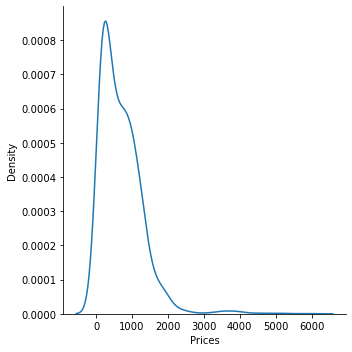

In [57]:
sns.displot(data, x="Prices", kind="kde", bw_adjust=2)

In [10]:
# 1 Price more than 10k, can be deleted
data = data[data["Prices"] < 10000]

In [11]:
data_numeric = data[['Prices','distance_km','flight_check_diff', "Flight_time",
                    'day_flight','month_flight','year_flight','day_of_week_flight','day_of_week_check',
                    'day_check','month_check','year_check',"Stops"]]
data_binary = data[['weekend_check','weekend_flight']]
data_category = data[['season','time_departure_bins','time_arrival_bins','check_time_bins']]

In [12]:
numerical_features = data[['distance_km','flight_check_diff', "Flight_time",
                    'day_flight','month_flight','year_flight','day_of_week_flight','day_of_week_check',
                    'day_check','month_check','year_check','Stops']].columns
binary_features = data[['weekend_check','weekend_flight']].columns
categorical_features = data[['season','time_departure_bins','time_arrival_bins','check_time_bins']].columns

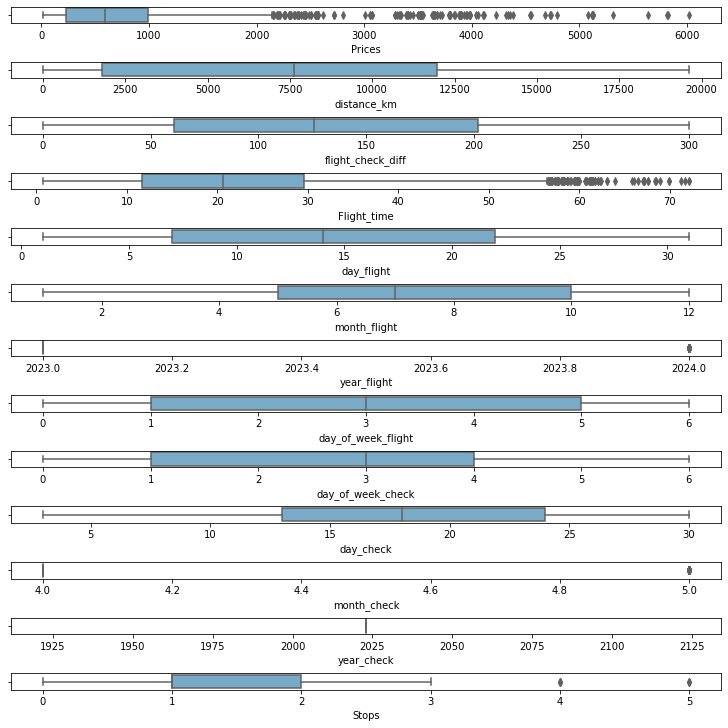

In [13]:
fig, axes = plt.subplots(len(data_numeric.columns), 1, figsize=(10,10), constrained_layout=True)


for i, col in enumerate(data_numeric):
    sns.boxplot(x=data[col], palette='Blues_r', ax=axes[i])

Only flight check difference has a significant amount of outliers, I decide to keep them because they could give valuable information.

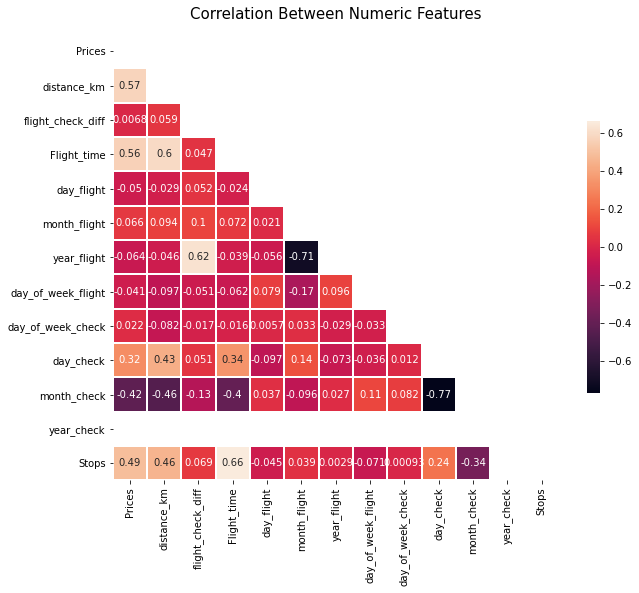

In [14]:
corr = data_numeric.corr()

fig, ax = plt.subplots(figsize=(10,10))

mask = np.triu(np.ones_like(corr, dtype=bool))

graph = sns.heatmap(corr, annot=True, mask = mask, 
                    square=True, linewidths=1, cbar_kws={"shrink": .5})

graph.set_title("Correlation Between Numeric Features", fontsize = 15, pad = 15)
plt.show()

In [15]:
#Flight time very correlated with distance
data = data.drop(columns = ["year_check","year_flight","Flight_time"])

In [16]:
# Based on correlation matrix
numerical_features = data[['distance_km','flight_check_diff',
                    'day_flight','month_flight','day_of_week_flight','day_of_week_check',
                    'day_check','month_check','Stops']].columns
binary_features = data[['weekend_check','weekend_flight']].columns
categorical_features = data[['season','time_departure_bins','time_arrival_bins','check_time_bins']].columns

In [17]:
# Cheapest flights
data.sort_values(by = "Prices").head()

,Prices,Stops,Check_weekday,distance_km,season,flight_check_diff,day_flight,month_flight,day_of_week_flight,weekend_flight,day_of_week_check,day_check,month_check,weekend_check,time_departure_bins,time_arrival_bins,check_time_bins
6872,16,0,Wednesday,748.757887,Mid season,143,23,9,5,1,2,3,5,0,afternoon,afternoon,afternoon
7836,16,0,Thursday,695.082783,High season,63,6,7,3,0,3,4,5,0,afternoon,afternoon,night
6871,16,0,Wednesday,748.757887,Mid season,143,23,9,5,1,2,3,5,0,evening,evening,afternoon
6870,16,0,Wednesday,748.757887,Mid season,143,23,9,5,1,2,3,5,0,afternoon,evening,afternoon
7956,16,0,Thursday,6520.866467,Mid season,163,14,10,5,1,3,4,5,0,evening,evening,morning


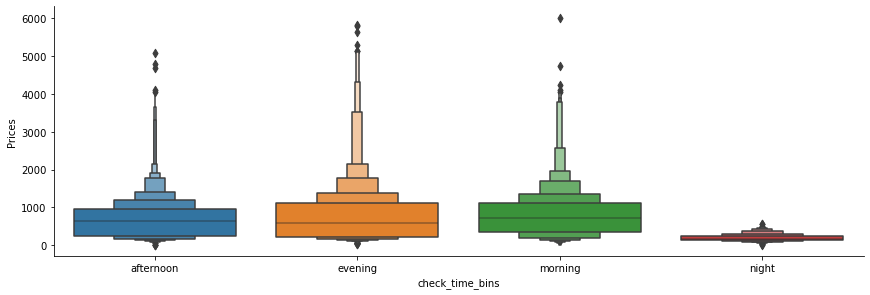

In [19]:
# Is there a pattern in the moment we check the flight and its price?
sns.catplot(y = "Prices", x = "check_time_bins", data = data, 
            kind="boxen", height = 4, aspect = 3)
plt.show()

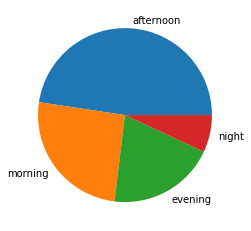

In [20]:
plt.pie(data['check_time_bins'].value_counts(),labels=['afternoon','morning','evening','night'])
plt.show()

A limitation of this project is that more flights should be scraped that are checked at night

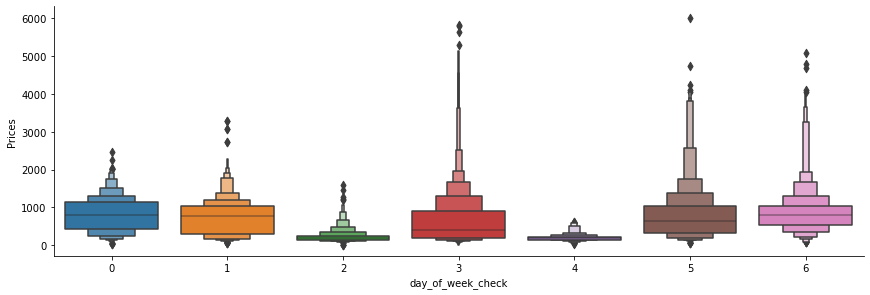

In [21]:
sns.catplot(y = "Prices", x = "day_of_week_check", data = data, 
            kind="boxen", height = 4, aspect = 3)
plt.show()

A limitation of this project is that more flights should be scraped on Friday and Wednesday

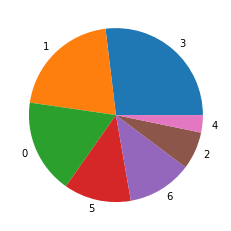

In [22]:
plt.pie(data['day_of_week_check'].value_counts(),labels=['3','1','0','5','6','2','4'])
plt.show()

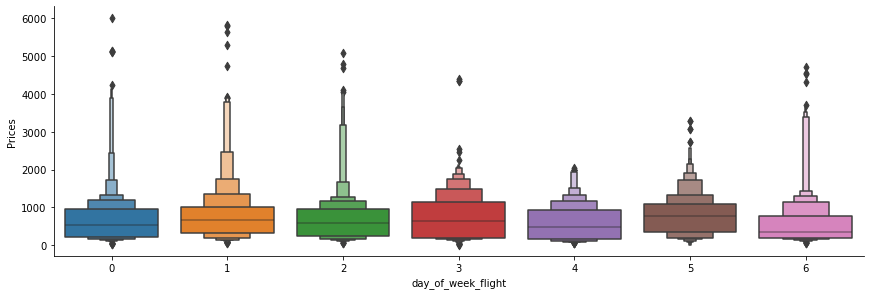

In [23]:
sns.catplot(y = "Prices", x = "day_of_week_flight", data = data, 
            kind="boxen", height = 4, aspect = 3)
plt.show()

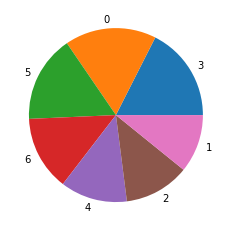

In [24]:
plt.pie(data['day_of_week_flight'].value_counts(),labels=['3','0','5','6','4','2','1'])
plt.show()

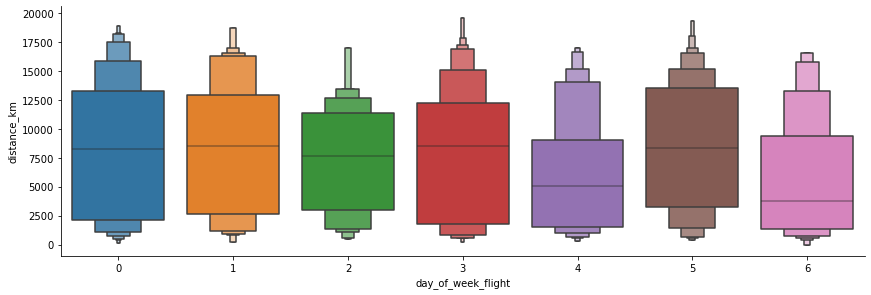

In [59]:
sns.catplot(y = "distance_km", x = "day_of_week_flight", data = data, 
            kind="boxen", height = 4, aspect = 3)
plt.show()

A conclusion from these graphs is that flights on Mondays and Fridays are cheaper

## Models

### Define train and test set

In [26]:
target = data.Prices
df = data.drop('Prices', axis=1)

X, y = df, target

# separate train and test data
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

### Prepare pipeline

In [28]:
def evaluate(model, target_train, target_test):
    target_train_pred = model.predict(X_train)
    target_test_pred = model.predict(X_test)
    r2_test = r2_score(target_test, target_test_pred)
    r2_train = r2_score(target_train, target_train_pred)
    mse_test = mean_squared_error(target_test, target_test_pred)

    print('Model Performance')
    print(f"R2 on test data: {r2_test}")
    print(f"R2 on training data: {r2_train}")
    print(f"RMSE on test data: {np.sqrt(mse_test)}")
    
    return target_test_pred

In [29]:
# creating pipeline for categorical features
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

# creating pipeline for numeric features
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

# creating a pipeline for binary features
bin_pipe = Pipeline([
    ("imputer", SimpleImputer(missing_values=np.nan, strategy='constant'))
])

# creating the processor for each of our column transformer pipelines
preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("num", num_pipe, numerical_features),
    ("bin", bin_pipe, binary_features)
])

### Baseline model Decision Tree

In [30]:
pipe_dt = Pipeline([
    ("preprocessor", preprocessor),
    ("model", tree.DecisionTreeClassifier(random_state = 42))
])

In [31]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['season', 'time_departure_bins', 'time_arrival_bins',
       'check_time_bins'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),...
                                                                   MinMaxScaler())]),
                                                  Index(['distance_km', 'flight_check_diff', 'day_flight', 'month_flight',
       'day_of_week_flight', 'day_of_week_check', 'day_check', 'month_check',
       'Stops'],
      dtype='object')),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  Index(['weekend_check', 'weekend_flight'], dtype='object'))])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [32]:
evaluate(pipe_dt, y_train, y_test)

Model Performance
R2 on test data: 0.8024181816530463
R2 on training data: 0.8823910824778396
RMSE on test data: 260.80893134877164


array([ 245, 1069,   16, ...,  247,  231,  869])

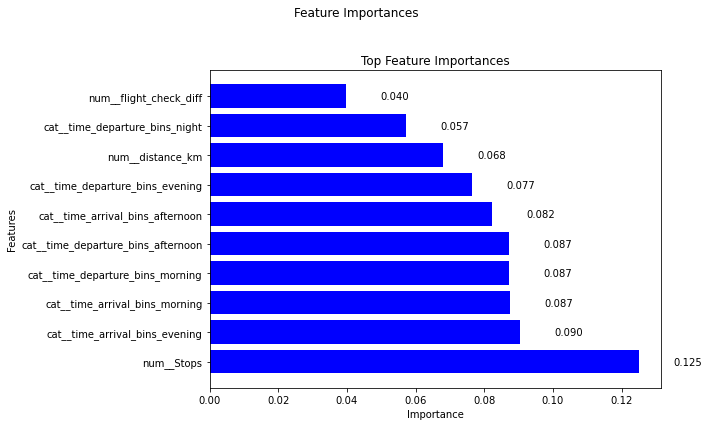

In [33]:
importances = pipe_dt.named_steps['model'].feature_importances_

feature_names = pipe_dt.named_steps['preprocessor'].get_feature_names_out()

feature_importance_dict = dict(zip(feature_names, importances))

sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

sorted_features = [item[0] for item in sorted_feature_importances]
sorted_importances = [item[1] for item in sorted_feature_importances]

top_n = 10
top_features = sorted_features[:top_n]
top_importances = sorted_importances[:top_n]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_importances, color='blue')

for i, (feature, importance) in enumerate(zip(top_features, top_importances)):
    plt.text(importance + 0.01, i, f'{importance:.3f}', va='center')

plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top Feature Importances')

plt.suptitle('Feature Importances')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

These feature importances do not seem logical. It will be checked again in further models.

## Linear Regression

In [34]:
# Creating the new pipeline

# create pipeline
pipe_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# fit pipeline
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['season', 'time_departure_bins', 'time_arrival_bins',
       'check_time_bins'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['distance_km', 'flight_check_diff', 'day_flight', 'month_flight',
       'day_of_week_flight', 'day_of_week_check', 'day_check', 'month_check',
       'Stops'],
      dtype='object')),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  Index(['weekend_check', 'weekend_flight'], dtype='object'))])),
                ('model', LinearRegression())])

In [35]:
evaluate(pipe_lr, y_train, y_test)

Model Performance
R2 on test data: 0.4389006651612889
R2 on training data: 0.43616689382129414
RMSE on test data: 439.51008779464036


array([ 536.,  696., -168., ...,  520.,  312., 1360.])

## Random Forest

In [36]:
# create pipeline
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=7, n_jobs=-1))
])
start = time.time()

# fit pipeline
pipe_rf.fit(X_train, y_train)

stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 1.7827210426330566s


In [37]:
target_test_pred = evaluate(pipe_rf, y_train, y_test)

Model Performance
R2 on test data: 0.8761135027604527
R2 on training data: 0.9407730636620992
RMSE on test data: 206.51944898063155


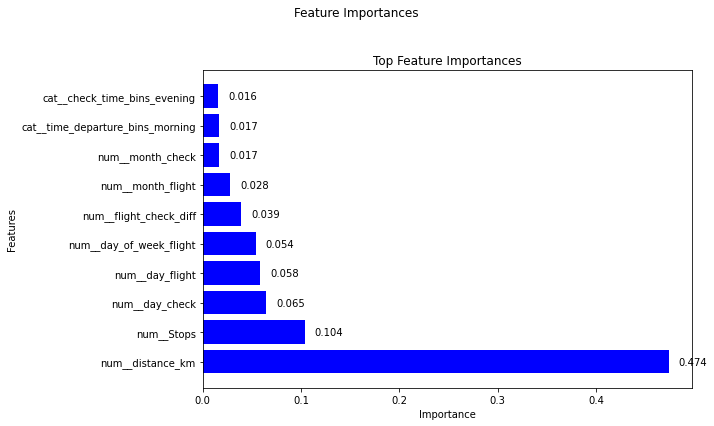

In [38]:
importances = pipe_rf.named_steps['model'].feature_importances_

feature_names = pipe_rf.named_steps['preprocessor'].get_feature_names_out()

feature_importance_dict = dict(zip(feature_names, importances))

sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

sorted_features = [item[0] for item in sorted_feature_importances]
sorted_importances = [item[1] for item in sorted_feature_importances]

top_n = 10
top_features = sorted_features[:top_n]
top_importances = sorted_importances[:top_n]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_importances, color='blue')

for i, (feature, importance) in enumerate(zip(top_features, top_importances)):
    plt.text(importance + 0.01, i, f'{importance:.3f}', va='center')

plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top Feature Importances')

plt.suptitle('Feature Importances')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

These feature importances make sense:
1) Distance between locations
2) Number of stops
3) Day the flight is checked (1st to 31st of the month)
4) Day of the flight (1st to 31st of the month)
5) Day of the week of the flight (Monday to Sunday)

### Further insights in feature importances

#### Day check

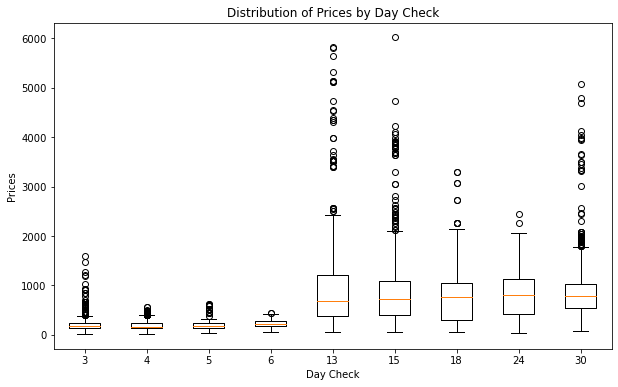

In [39]:
data_by_day = []
day_labels = sorted(data['day_check'].unique())  # Get unique 'day_check' values and sort them

for day in day_labels:
    prices_day = data[data['day_check'] == day]['Prices']
    data_by_day.append(prices_day)

plt.figure(figsize=(10, 6))
plt.boxplot(data_by_day, labels=day_labels)

plt.xlabel('Day Check')
plt.ylabel('Prices')

plt.title('Distribution of Prices by Day Check')

plt.show()

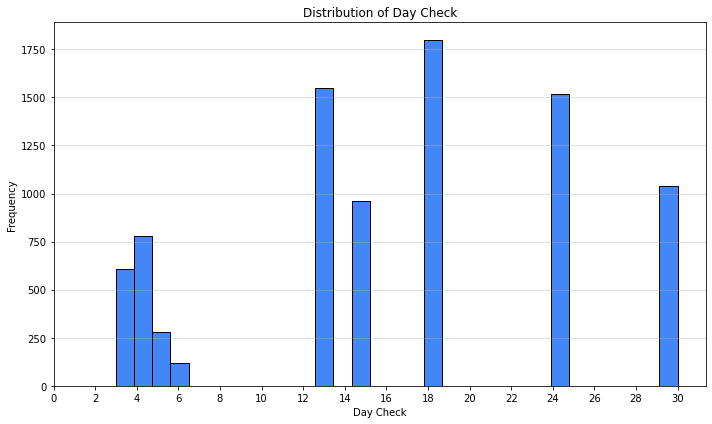

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(data['day_check'], bins=31, color='#4287f5', edgecolor='black')

plt.xlabel('Day Check')
plt.ylabel('Frequency')

plt.title('Distribution of Day Check')

plt.xticks(range(0, 31, 2))  # Adjust x-axis ticks if needed

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

plt.show()

The distribution looks balanced between low and high values so it is clear that the earlier the month you check flight prices, the lower the prices

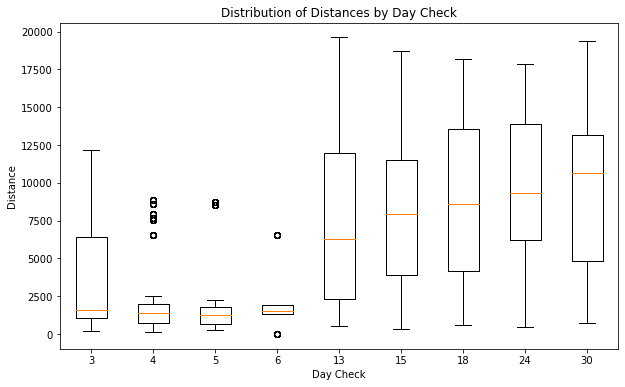

In [41]:
data_by_day = []
day_labels = sorted(data['day_check'].unique())  # Get unique 'day_check' values and sort them

for day in day_labels:
    prices_day = data[data['day_check'] == day]['distance_km']
    data_by_day.append(prices_day)

plt.figure(figsize=(10, 6))
plt.boxplot(data_by_day, labels=day_labels)

plt.xlabel('Day Check')
plt.ylabel('Distance')

plt.title('Distribution of Distances by Day Check')

plt.show()

However it is also clear that the flights scraped in the beginning of the month, have a lower distance between locations. Consequently, to improve the model, flights with longer distances should be scraped in the beginning of the month.

In the end the random forest model took into account the data points with lower distance in the beginning of the month and takes this into account.

#### Day flight

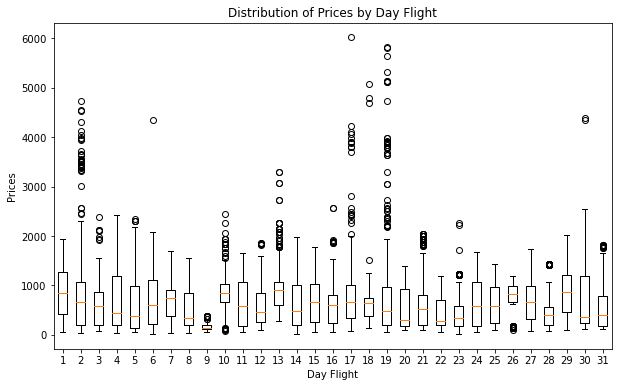

In [42]:
data_by_day = []
day_labels = sorted(data['day_flight'].unique())  # Get unique 'day_flight' values and sort them

for day in day_labels:
    prices_day = data[data['day_flight'] == day]['Prices']
    data_by_day.append(prices_day)

plt.figure(figsize=(10, 6))
plt.boxplot(data_by_day, labels=day_labels)

plt.xlabel('Day Flight')
plt.ylabel('Prices')

plt.title('Distribution of Prices by Day Flight')
plt.show()

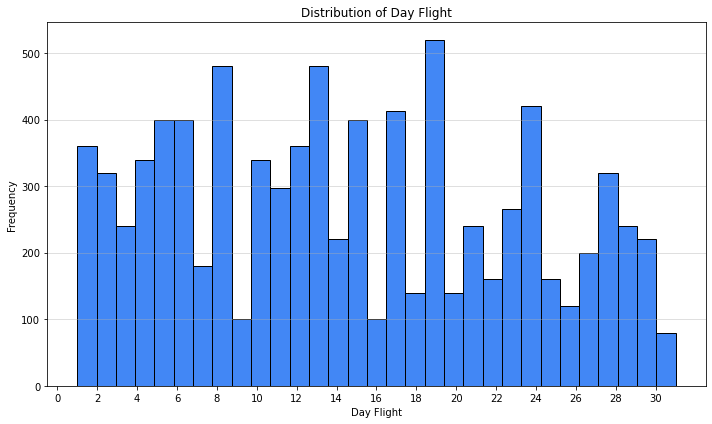

In [43]:
plt.figure(figsize=(10, 6))
plt.hist(data['day_flight'], bins=31, color='#4287f5', edgecolor='black')

plt.xlabel('Day Flight')
plt.ylabel('Frequency')

plt.title('Distribution of Day Flight')

plt.xticks(range(0, 31, 2))  

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

plt.show()

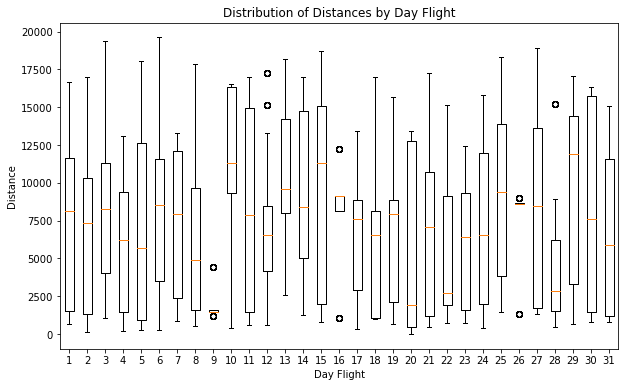

In [44]:
data_by_day = []
day_labels = sorted(data['day_flight'].unique())  # Get unique 'day_check' values and sort them

for day in day_labels:
    prices_day = data[data['day_flight'] == day]['distance_km']
    data_by_day.append(prices_day)

plt.figure(figsize=(10, 6))
plt.boxplot(data_by_day, labels=day_labels)

plt.xlabel('Day Flight')
plt.ylabel('Distance')

plt.title('Distribution of Distances by Day Flight')

plt.show()

The same logic of day check goes for day flight.

#### Distance

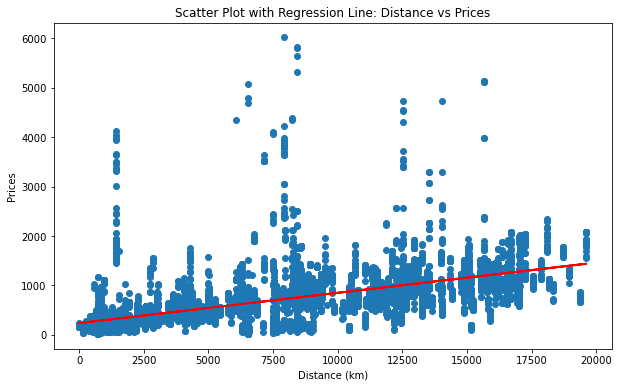

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(data['distance_km'], data['Prices'])

regression_model = LinearRegression()
X = data['distance_km'].values.reshape(-1, 1)
y = data['Prices'].values.reshape(-1, 1)
regression_model.fit(X, y)
y_pred = regression_model.predict(X)

plt.plot(X, y_pred, color='red', linewidth=2)

plt.xlabel('Distance (km)')
plt.ylabel('Prices')

plt.title('Scatter Plot with Regression Line: Distance vs Prices')

plt.show()

In [46]:
## TO BE FIXED (takes very long)
#explainer = shap.TreeExplainer(pipe_rf.named_steps['model'],n_jobs=-1)
#shap_values = explainer.shap_values(preprocessor.transform(X_test))
#shap.summary_plot(shap_values, preprocessor.transform(X_test))

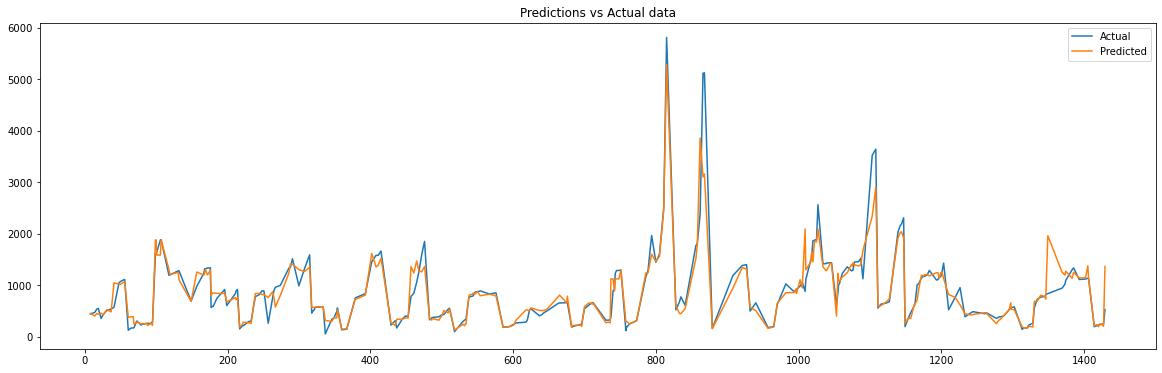

In [50]:
plt.figure(figsize= (20,6))

df3 = pd.DataFrame({"Y_test": y_test , "Y_pred" : target_test_pred})
df3 = df3.sort_index()
plt.plot(df3[:300])
plt.legend(["Actual" , "Predicted"])
plt.title("Predictions vs Actual data")
plt.show()

## Gradient Boosting

In [51]:
# Creating new pipeline for features
pipe_gb = Pipeline([
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(random_state=7))
])

pipe_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['season', 'time_departure_bins', 'time_arrival_bins',
       'check_time_bins'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),...
                                                                   MinMaxScaler())]),
                                                  Index(['distance_km', 'flight_check_diff', 'day_flight', 'month_flight',
       'day_of_week_flight', 'day_of_week_check', 'day_check', 'month_check',
       'Stops'],
      dtype='object')),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  Index(['weekend_check', 'weekend_flight'], dtype='object'))])),
                ('model', GradientBoostingRegressor(random_state=7))])

In [52]:
evaluate(pipe_gb, y_train, y_test)

Model Performance
R2 on test data: 0.7070716183755724
R2 on training data: 0.7127157173557066
RMSE on test data: 317.56285429190046


array([ 339.23690674,  646.65839768,  131.56466101, ...,  244.41102216,
        214.07349964, 1048.27332902])

## Extra Trees

In [56]:
pipe_et = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ExtraTreesClassifier(random_state = 42))
])

pipe_et.fit(X_train, y_train)

The least populated class in y has only 1 members, which is less than n_splits=3.


Cross-Validation Scores: [0.14904679 0.14254766 0.14818024]
Mean CV Score: 0.14659156556903521


In [54]:
evaluate(pipe_et, y_train, y_test)

Model Performance
R2 on test data: 0.7765458820333089
R2 on training data: 0.8823910824778396
RMSE on test data: 277.3595678305128


array([ 245, 1069,   16, ...,  247,  161,  869])

## Gridsearch

In [60]:
# Creating parameter grid
param_grid = {
    "model__n_estimators": range(200, 500, 100),
    "model__max_features": np.linspace(0.1,0.8,8)
}

In [61]:
grid = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring="neg_mean_absolute_error", 
    cv=2,
    n_jobs=-1
)

start=time.time()

grid.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid.best_params_
best_score = grid.best_score_

stop=time.time()
print(f"Training time: {stop-start}s")

Training time: 55.47911095619202s


In [62]:
best_params

{'model__max_features': 0.7000000000000001, 'model__n_estimators': 400}

In [63]:
best_score

-111.39897491479783

In [64]:
# create pipeline
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=7, n_jobs=-1, max_features = 0.8, n_estimators = 400))
])
start = time.time()

# fit pipeline
pipe_rf.fit(X_train, y_train)

stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 3.300365924835205s


In [65]:
target_test_pred = evaluate(pipe_rf, y_train, y_test)

Model Performance
R2 on test data: 0.8806393791118157
R2 on training data: 0.9414296248973
RMSE on test data: 202.71202183893743
